## import moduels

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


## hyperparameters

In [3]:
args = {"train_path" : "/kaggle/input/titanic/train.csv",
        "test_path" : "/kaggle/input/titanic/test.csv",
        "result_path" : "/kaggle/input/titanic/gender_submission.csv",
        "epochs":2000,
        "lr" : 0.005,
        "batch_size" : 512,
        "num_labels" : 2
       }

## check the data shape and submission form

In [4]:
train = pd.read_csv(args["train_path"])
test = pd.read_csv(args["test_path"])
submission_form = pd.read_csv(args["result_path"])

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
submission_form.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## preprocessing

### 자료 유형
- survived : 생존=1, 죽음=0
- pclass: 승객등급 / 1등급= 1, 2등급= 2, 3등급= 3 
- sibsp: 동승한 형제 또는 배우자 수
- parch: 동승한 부모 또는 자녀 수
- ticket: 티켓 번호
- cabin: 선실 번호
- embarked: 탑승장소 / Southhampton, Cherbourg, Queenstown

In [8]:
train.info()
#test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
# 불필요 행 삭제
train = train.drop(axis = 1 ,columns = ['PassengerId','Name', 'Ticket','Cabin','Embarked'])
test = test.drop(axis = 1 ,columns = ['PassengerId','Name', 'Ticket','Cabin','Embarked'])
train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500
...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000
887,1,1,female,19.0,0,0,30.0000
888,0,3,female,NaN,1,2,23.4500
889,1,1,male,26.0,0,0,30.0000


In [10]:
for idx, sex in enumerate(train.loc[:, "Sex"]):
    if sex == 'male':
        train.loc[idx, "Sex"] = 1
    elif sex == 'female':
        train.loc[idx, "Sex"] = 2

      
for idx, sex in enumerate(test.loc[:, "Sex"]):
    if sex == 'male':
        test.loc[idx, "Sex"] = 1
    elif sex == 'female':
        test.loc[idx, "Sex"] = 2
train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,1,22.0,1,0,7.2500
1,1,1,2,38.0,1,0,71.2833
2,1,3,2,26.0,0,0,7.9250
3,1,1,2,35.0,1,0,53.1000
4,0,3,1,35.0,0,0,8.0500
...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000
887,1,1,2,19.0,0,0,30.0000
888,0,3,2,NaN,1,2,23.4500
889,1,1,1,26.0,0,0,30.0000


In [11]:
train.info()
# test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
dtypes: float64(2), int64(4), object(1)
memory usage: 48.9+ KB


In [12]:
train = train.astype(float)
test = test.astype(float)

train.dtypes

Survived    float64
Pclass      float64
Sex         float64
Age         float64
SibSp       float64
Parch       float64
Fare        float64
dtype: object

In [13]:
# 결측치 제거
train = train.fillna(train.mean())
test = test.fillna(test.mean())
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    891 non-null    float64
 2   Sex       891 non-null    float64
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    float64
 5   Parch     891 non-null    float64
 6   Fare      891 non-null    float64
dtypes: float64(7)
memory usage: 48.9 KB


In [14]:
train
#test

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0.0,3.0,1.0,22.000000,1.0,0.0,7.2500
1,1.0,1.0,2.0,38.000000,1.0,0.0,71.2833
2,1.0,3.0,2.0,26.000000,0.0,0.0,7.9250
3,1.0,1.0,2.0,35.000000,1.0,0.0,53.1000
4,0.0,3.0,1.0,35.000000,0.0,0.0,8.0500
...,...,...,...,...,...,...,...
886,0.0,2.0,1.0,27.000000,0.0,0.0,13.0000
887,1.0,1.0,2.0,19.000000,0.0,0.0,30.0000
888,0.0,3.0,2.0,29.699118,1.0,2.0,23.4500
889,1.0,1.0,1.0,26.000000,0.0,0.0,30.0000


In [15]:
x_train = train.drop(columns="Survived")
y_train = train.loc[:,"Survived"].astype(int)
#test = test

In [16]:
x_train

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3.0,1.0,22.000000,1.0,0.0,7.2500
1,1.0,2.0,38.000000,1.0,0.0,71.2833
2,3.0,2.0,26.000000,0.0,0.0,7.9250
3,1.0,2.0,35.000000,1.0,0.0,53.1000
4,3.0,1.0,35.000000,0.0,0.0,8.0500
...,...,...,...,...,...,...
886,2.0,1.0,27.000000,0.0,0.0,13.0000
887,1.0,2.0,19.000000,0.0,0.0,30.0000
888,3.0,2.0,29.699118,1.0,2.0,23.4500
889,1.0,1.0,26.000000,0.0,0.0,30.0000


In [17]:
y_train

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [18]:
def one_hot(labels: list):
    list_size = len(labels)
    one_hot_list = []
    
    for idx, label in enumerate(labels):
        if label == 1:
            one_hot_list.append([0,1])
        else:
            one_hot_list.append([1,0])
    return one_hot_list

In [19]:
test

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3.0,1.0,34.50000,0.0,0.0,7.8292
1,3.0,2.0,47.00000,1.0,0.0,7.0000
2,2.0,1.0,62.00000,0.0,0.0,9.6875
3,3.0,1.0,27.00000,0.0,0.0,8.6625
4,3.0,2.0,22.00000,1.0,1.0,12.2875
...,...,...,...,...,...,...
413,3.0,1.0,30.27259,0.0,0.0,8.0500
414,1.0,2.0,39.00000,0.0,0.0,108.9000
415,3.0,1.0,38.50000,0.0,0.0,7.2500
416,3.0,1.0,30.27259,0.0,0.0,8.0500


In [20]:
type(x_train), type(y_train), type(test) 

(pandas.core.frame.DataFrame,
 pandas.core.series.Series,
 pandas.core.frame.DataFrame)

In [21]:
#데이터 타입 변경
x_train = torch.tensor(x_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values)
test = torch.tensor(test.values, dtype=torch.float32)

In [22]:
x_train.shape, y_train.shape, test.shape

(torch.Size([891, 6]), torch.Size([891]), torch.Size([418, 6]))

## data load

In [23]:
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= args['batch_size'],shuffle= True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size= len(test_dataset), shuffle= False)

## Model defintion

In [24]:
class Model(nn.Module):
    def __init__(self, num_classes):
        super(Model, self).__init__()
        
        self.features = nn.Sequential(
            nn.Linear(6,16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(16,16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(16,num_classes),
        )
    def __call__(self, x):
        x = self.features(x)
        return x
        

In [25]:
model = Model(num_classes = args['num_labels'])
num_epochs = args['epochs']
optimizer = torch.optim.Adam(params = model.parameters(), lr = args['lr'])
loss_fn = nn.CrossEntropyLoss()

100%|██████████| 2/2 [00:00<00:00, 118.11it/s]


epoch:100
train_loss:0.0009809333734908355, train_acc:0.8092031425364759


100%|██████████| 2/2 [00:00<00:00, 120.13it/s]


epoch:200
train_loss:0.0009181841321532039, train_acc:0.8260381593714927


100%|██████████| 2/2 [00:00<00:00, 79.42it/s]


epoch:300
train_loss:0.0008767251213793, train_acc:0.8316498316498316


100%|██████████| 2/2 [00:00<00:00, 114.75it/s]


epoch:400
train_loss:0.0008798925630438876, train_acc:0.8282828282828283


100%|██████████| 2/2 [00:00<00:00, 108.33it/s]


epoch:500
train_loss:0.0008659674195461937, train_acc:0.8507295173961841


100%|██████████| 2/2 [00:00<00:00, 114.85it/s]


epoch:600
train_loss:0.0008638165013155954, train_acc:0.8361391694725028


100%|██████████| 2/2 [00:00<00:00, 101.49it/s]


epoch:700
train_loss:0.0008755591515071197, train_acc:0.8305274971941639


100%|██████████| 2/2 [00:00<00:00, 117.39it/s]


epoch:800
train_loss:0.0008617530166099369, train_acc:0.8338945005611672


100%|██████████| 2/2 [00:00<00:00, 118.54it/s]


epoch:900
train_loss:0.0008137192991044787, train_acc:0.8552188552188552


100%|██████████| 2/2 [00:00<00:00, 120.25it/s]


epoch:1000
train_loss:0.0008580413062698244, train_acc:0.8417508417508418


100%|██████████| 2/2 [00:00<00:00, 117.12it/s]


epoch:1100
train_loss:0.0008087717791063885, train_acc:0.8462401795735129


100%|██████████| 2/2 [00:00<00:00, 104.62it/s]


epoch:1200
train_loss:0.0008073735116708159, train_acc:0.8383838383838383


100%|██████████| 2/2 [00:00<00:00, 98.77it/s]


epoch:1300
train_loss:0.0008515580802921762, train_acc:0.8372615039281706


100%|██████████| 2/2 [00:00<00:00, 119.09it/s]


epoch:1400
train_loss:0.0008778595830722557, train_acc:0.8215488215488216


100%|██████████| 2/2 [00:00<00:00, 116.46it/s]


epoch:1500
train_loss:0.0007869571146338877, train_acc:0.8574635241301908


100%|██████████| 2/2 [00:00<00:00, 103.65it/s]


epoch:1600
train_loss:0.0007959823014358881, train_acc:0.8540965207631874


100%|██████████| 2/2 [00:00<00:00, 102.84it/s]


epoch:1700
train_loss:0.0008370869957102937, train_acc:0.8451178451178452


100%|██████████| 2/2 [00:00<00:00, 120.66it/s]


epoch:1800
train_loss:0.000801392978289312, train_acc:0.8484848484848485


100%|██████████| 2/2 [00:00<00:00, 114.59it/s]


epoch:1900
train_loss:0.0008059884228155134, train_acc:0.8462401795735129


100%|██████████| 2/2 [00:00<00:00, 118.01it/s]


epoch:2000
train_loss:0.0007816477857454858, train_acc:0.8518518518518519


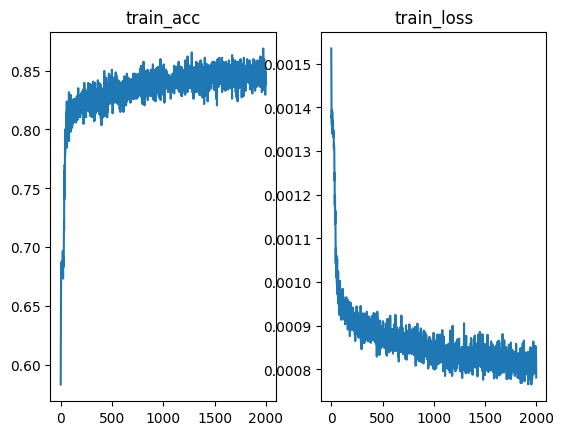

In [26]:
acc_list = []
loss_list = []


model.train()
model.zero_grad()

for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    
    
    for data, label in tqdm(train_loader): 
        output = model(data)
        output_label = output.argmax(dim=1)
        loss = loss_fn(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += (output_label == label).sum().item()
        
    train_loss /= len(train_dataset)
    train_acc /= len(train_dataset)

    if (epoch + 1)% 100 == 0:
        print(f"epoch:{epoch + 1}")
        print(f"train_loss:{train_loss}, train_acc:{train_acc}")
    acc_list.append(train_acc)
    loss_list.append(train_loss)

plt.subplot(1,2,1)
plt.title('train_acc')
plt.plot(acc_list)

plt.subplot(1,2,2)
plt.title('train_loss')
plt.plot(loss_list)


In [27]:
def one_hot_decode(data: torch.tensor):
    return data.argmax(dim=1)

In [28]:
model.eval()
for data in test_loader:
    output = model(data[0])
print(output.shape)

torch.Size([418, 2])


In [29]:
submission_form['Survived'] = one_hot_decode(output)
submission_form.to_csv('submission.csv', index=False)
submission_form

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
